# Load libraries and data

In [1]:
import pandas as pd
import numpy as np
# import pyreadr # read r to python

# for modeling
import xgboost as xgb
from sklearn.model_selection import train_test_split

# for interpretation
import shap
import matplotlib.pyplot as plt # for export SHAP plot to png

# for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import time
from shuffle import shuffle_df

import warnings
warnings.filterwarnings("ignore")

/Users/christinenorth/miniconda3/envs/oxford_sml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
vis_path = "SB22_GroupAssessedPractical2025/figures"

if not os.path.exists(vis_path):
    # if the folder directory is not exist then create it.
    os.makedirs(vis_path)


model_path = "SB22_GroupAssessedPractical2025/models"
if not os.path.exists(model_path):
    # if the folder directory is not exist then create it.
    os.makedirs(model_path)

In [3]:
path = 'data'

X_fps_train = pd.read_csv(f'{path}/X_fps_train.csv', index_col = 0)
X_embed_train = pd.read_csv(f'{path}/X_embed_train.csv', index_col = 0)
X_join_train = pd.concat([X_fps_train, X_embed_train], axis = 1)
y_train0 = pd.read_csv(f"{path}/y_train.csv", index_col = 0)

X_fps_train, y_train = shuffle_df(trainX_df = X_fps_train, trainY_df = y_train0)
X_embed_train, y_train = shuffle_df(trainX_df = X_embed_train, trainY_df = y_train0)
X_join_train, y_train = shuffle_df(trainX_df = X_join_train, trainY_df = y_train0)

X_fps_test = pd.read_csv(f'{path}/X_fps_public_test.csv', index_col = 0)
X_embed_test = pd.read_csv(f'{path}/X_embed_public_test.csv', index_col = 0)
X_join_test = pd.concat([X_fps_test, X_embed_test], axis = 1)
y_test = pd.read_csv(f"{path}/y_public_test.csv", index_col = 0)

X_fps_test, X_embed_test, X_join_test, y_test = np.array(X_fps_test), np.array(X_embed_test), np.array(X_join_test), y_test.iloc[:, 0].to_numpy()

n, p_fps = X_fps_train.shape
n, p_embed = X_embed_train.shape
n, p_join = X_join_train.shape

# XGBoost Training

## 1. Initial model configuration

Set up an appropriate start for the following grid search

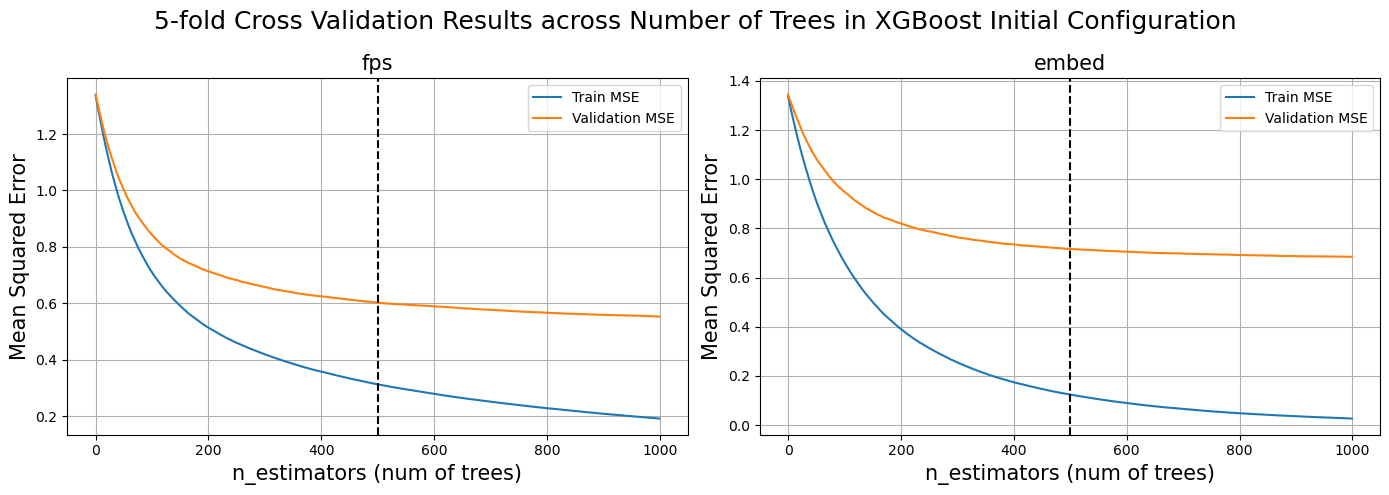

In [4]:
def xgb_inital(X_train, y_train):
    params = {"objective":"reg:squarederror", 'colsample_bytree': 0.8, 'learning_rate': 0.01,
                'max_depth': 5, 'subsample':0.5}
    data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=1000, 
                    metrics='rmse', 
                    as_pandas=True, seed=0)
    cv_res = pd.DataFrame(np.array(cv_results.iloc[:, [0,2]])**2) # transform rmse to mse
    cv_res.columns = ['train-mse', 'validation-mse']

    return cv_res

fps_cv_res = xgb_inital(X_fps_train, y_train)
embed_cv_res = xgb_inital(X_embed_train, y_train)


## Visualisation for exploring n_estimators as an initial configuration
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('5-fold Cross Validation Results across Number of Trees in XGBoost Initial Configuration', fontsize=18)

# fps subplot
axes[0].plot(fps_cv_res['train-mse'], label='Train MSE')
axes[0].plot(fps_cv_res['validation-mse'], label='Validation MSE')
axes[0].set_xlabel('n_estimators (num of trees)', size = 15)
axes[0].set_ylabel('Mean Squared Error', size = 15)
axes[0].set_title('fps', size = 15)
axes[0].axvline(x = 500, color = 'black', linestyle = '--')
axes[0].legend()
axes[0].grid(True)

# embed subplot
axes[1].plot(embed_cv_res['train-mse'], label='Train MSE')
axes[1].plot(embed_cv_res['validation-mse'], label='Validation MSE')
axes[1].set_xlabel('n_estimators (num of trees)', size = 15)
axes[1].set_ylabel('Mean Squared Error', size = 15)
axes[1].set_title('embed', size = 15)
axes[1].axvline(x = 500, color = 'black', linestyle = '--')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
# plt.savefig(f"{vis_path}/XGBoost_inital.png", dpi=150, bbox_inches='tight')
plt.show()

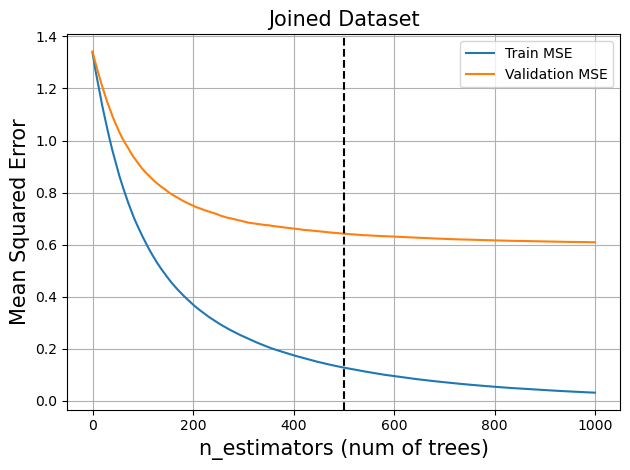

In [18]:
join_cv_res = xgb_inital(X_join_train, y_train)

## Visualisation for exploring n_estimators as an initial configuration
plt.plot(join_cv_res['train-mse'], label='Train MSE')
plt.plot(join_cv_res['validation-mse'], label='Validation MSE')
plt.xlabel('n_estimators (num of trees)', size = 15)
plt.ylabel('Mean Squared Error', size = 15)
plt.axvline(x = 500, color = 'black', linestyle = '--')
plt.legend()
plt.grid(True)

plt.title('Joined Dataset', fontsize=15)
plt.tight_layout()
plt.show()

## 2. Hyperparameter Tuning via Grid search cross validation on training set

In [5]:
def xgb_grid_search(X, y, n_estimators, param_grid):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators = n_estimators, 
                                 n_jobs=-1, # parallel computing
                                 random_state = 666,
                                 eval_metric = mean_squared_error
                                 )
    
    # Set up the grid search with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # GridSearchCV maximizes score, so use negative MSE
                               cv=5,
                               verbose=5)
    
    
    grid_search.fit(X, y)
    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    return grid_search, best_model

In [ ]:
param_grid_fps = {'colsample_bytree': [0.2, 0.5, 0.8], 
                  'learning_rate': [0.005, 0.01], 
                  'max_depth': [5, 7, 10, 15], 
                  'subsample': [0.2, 0.5, 0.8]}
param_grid_embed = {'colsample_bytree': [0.2, 0.5, 0.8], 
                    'learning_rate': [0.005, 0.01], 
                    'max_depth': [5, 10, 15], 
                    'subsample': [0.2, 0.5, 0.8]}

grid_search_fps, best_model_fps = xgb_grid_search(X = X_fps_train, y = y_train, n_estimators = 500, param_grid = param_grid_fps)
grid_search_embed, best_model_embed = xgb_grid_search(X = X_embed_train, y = y_train, n_estimators = 500, param_grid = param_grid_embed)

In [ ]:
param_grid_join = {'colsample_bytree': [0.2, 0.5, 0.8], 'learning_rate': [0.01], 'max_depth': [5, 10, 20, 30], 'subsample': [0.2, 0.5, 0.8], 
              }
grid_search_joint, best_model_joint = xgb_grid_search(X = X_join_train, y = y_train, n_estimators = 500, param_grid = param_grid_join)

### Post pruning using gamma

In [7]:
def get_split_gains_df(best_model):
    # Get all tree splits in JSON format
    trees = best_model.get_booster().get_dump(dump_format='json', with_stats=True)
    
    # Extract split gains
    split_gains = []
    for tree in trees:
        tree_data = eval(tree)  # Convert JSON string to dictionary
        nodes = [tree_data]
        while nodes:
            node = nodes.pop()
            if 'split' in node:  # Internal split node
                split_gains.append(node['gain'])
                nodes.append(node['children'][0])
                nodes.append(node['children'][1])
    
    # Get minimum partition loss (smallest split gain)
    min_partition_loss = min(split_gains) if split_gains else None
    print("Minimum Partition Loss (min gain):", min_partition_loss)

    # make dataframe about split gains
    gaindf = pd.DataFrame(split_gains)
    gaindf.columns = ['gain']
    gaindf = gaindf.sort_values('gain')
    return gaindf

def get_cv_gammas(gaindf, bins = 4):
    nsplit = gaindf.shape[0] # num of splits
    gamma_candidates = []
    print(f'Sorting split gains and give candidates of gamma using {bins} bins amongst these gains')
    for i in range(1,4):
        gamma_candidates.append(gaindf.iloc[nsplit//bins*i, ]['gain'])
    return gamma_candidates

In [22]:
gaindf_fps = get_split_gains_df(best_model_fps)
gaindf_embed = get_split_gains_df(best_model_embed)
gaindf_join = get_split_gains_df(best_model_joint)

Minimum Partition Loss (min gain): 1.35129085e-06
Minimum Partition Loss (min gain): 1.01646765e-06
Minimum Partition Loss (min gain): 1.00114937e-06


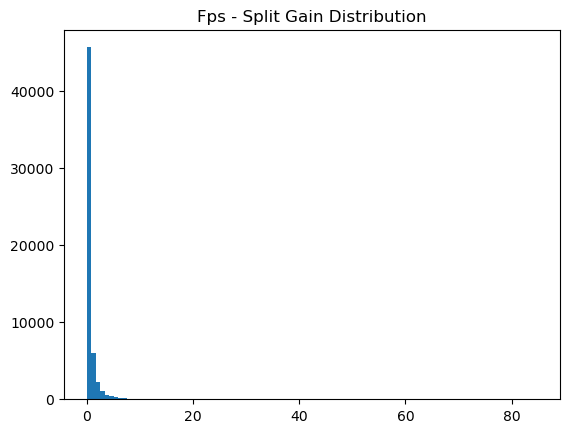

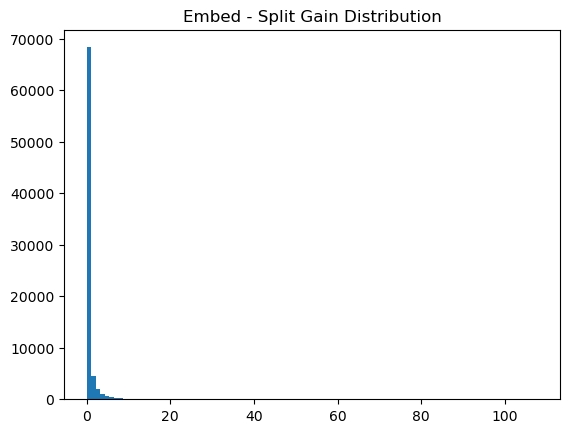

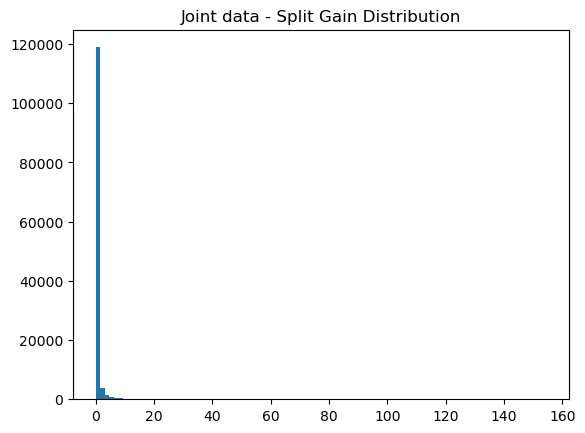

In [23]:
# glimpse at the gain distribution
plt.hist(gaindf_fps['gain'].tolist(), bins=100)
plt.title("Fps - Split Gain Distribution")
plt.show()

plt.hist(gaindf_embed['gain'].tolist(), bins=100)
plt.title("Embed - Split Gain Distribution")
plt.show()

plt.hist(gaindf_join['gain'].tolist(), bins=100)
plt.title("Joint data - Split Gain Distribution")
plt.show()

In [24]:
gamma_candidates_fps = get_cv_gammas(gaindf_fps)
gamma_candidates_embed = get_cv_gammas(gaindf_embed)
gamma_candidates_join = get_cv_gammas(gaindf_embed)

Sorting split gains and give candidates of gamma using 4 bins amongst these gains
Sorting split gains and give candidates of gamma using 4 bins amongst these gains
Sorting split gains and give candidates of gamma using 4 bins amongst these gains


In [25]:
param_grid1_fps = {'colsample_bytree': [0.5], 'learning_rate': [0.01], 'max_depth': [15], 'subsample': [0.5], 'gamma':gamma_candidates_fps}
grid_search_reg_fps, best_model_reg_fps = xgb_grid_search(X_fps_train, y_train, n_estimators=500, param_grid=param_grid1_fps)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.068823576, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.522 total time=   3.3s
[CV 2/5] END colsample_bytree=0.5, gamma=0.068823576, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.522 total time=   2.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0.068823576, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.556 total time=   3.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0.068823576, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.487 total time=   3.4s
[CV 5/5] END colsample_bytree=0.5, gamma=0.068823576, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.520 total time=   3.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0.248457938, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.522 total time=   2.5s
[CV 2/5] END colsample_bytree=0.5, gamma=0.248457938, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.525 total t

In [26]:
param_grid1_embed = {'colsample_bytree': [0.8], 'learning_rate': [0.01], 'max_depth': [15], 'subsample': [0.5], 'gamma':gamma_candidates_embed}
grid_search_reg_embed, best_model_reg_embed = xgb_grid_search(X_embed_train, y_train, n_estimators=500, param_grid=param_grid1_embed)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.0088365972, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.662 total time=  22.7s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0088365972, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.758 total time=  24.0s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0088365972, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.798 total time=  22.4s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0088365972, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.623 total time=  22.9s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0088365972, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.667 total time=  22.6s
[CV 1/5] END colsample_bytree=0.8, gamma=0.0710466057, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.668 total time=  15.7s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0710466057, learning_rate=0.01, max_depth=15, subsample=0.5;, score=-0.758 

In [33]:
param_grid1_join = {'colsample_bytree': [0.5], 'learning_rate': [0.01], 'max_depth': [5], 'subsample': [0.5], 'gamma':gamma_candidates_join}
grid_search_reg_join, best_model_reg_join = xgb_grid_search(X_join_train, y_train, n_estimators=500, param_grid=param_grid1_join)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.0088365972, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.603 total time=   4.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0088365972, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.688 total time=   3.9s
[CV 3/5] END colsample_bytree=0.5, gamma=0.0088365972, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.717 total time=   4.3s
[CV 4/5] END colsample_bytree=0.5, gamma=0.0088365972, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.586 total time=   4.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.0088365972, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.597 total time=   4.3s
[CV 1/5] END colsample_bytree=0.5, gamma=0.0710466057, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.613 total time=   4.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0710466057, learning_rate=0.01, max_depth=5, subsample=0.5;, score=-0.690 total t

## Evaluate on public test set

To ensure the validity of evaluation, change 5 different seeds and report the mean and standard error for the metrics (MSE, MAE)

In [31]:
def evaluate(X_train, y_train, X_test, y_test, learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
    mse_ls = []
    mae_ls = []
    time_ls = []
    for seed in [111, 222, 333, 444, 555]:
    
        t0 = time.time()
        xgb_eval = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma = gamma,
            n_jobs=-1,
            eval_metric = mean_squared_error,
            random_state = seed
        )
        xgb_eval.fit(X_train, y_train, verbose = 30)
        delta_t = time.time() - t0
    
        # Evaluate on the public test set
        y_pred_test = xgb_eval.predict(X_test)
        mse_ls.append(mean_squared_error(y_test, y_pred_test))
        mae_ls.append(mean_absolute_error(y_test, y_pred_test))
        time_ls.append(delta_t)
    print("Performance on Public Test Set: Mean (SE)")
    print(f'Mean Squared Error: {round(np.mean(mse_ls), 4)} ({round(np.std(mse_ls), 4)})')
    print(f'Mean Absolute Error: {round(np.mean(mae_ls), 4)} ({round(np.std(mae_ls), 4)})')
    print(f'Time: {round(np.mean(time_ls), 4)} ({round(np.std(time_ls), 4)})')

print("################################")
print("XGBoost Performance on Fps data:")
evaluate(X_fps_train, y_train, X_fps_test, y_test, 
         learning_rate = 0.01,
         n_estimators = 500,
         max_depth = 15, 
         subsample = 0.5, 
         colsample_bytree = 0.5,
         gamma = gamma_candidates_fps[0])

print("################################")
print("XGBoost Performance on embed data:")
evaluate(X_embed_train, y_train, X_embed_test, y_test, 
         learning_rate = 0.01,
         n_estimators = 500,
         max_depth = 15, 
         subsample = 0.5, 
         colsample_bytree = 0.8, 
         gamma = gamma_candidates_embed[0])

print("################################")
print("XGBoost Performance on joint data:")
evaluate(X_join_train, y_train, X_join_test, y_test, 
         learning_rate = 0.01,
         n_estimators = 599,
         max_depth = 5, 
         subsample = 0.5, 
         colsample_bytree = 0.5, 
         gamma = gamma_candidates_join[0])

################################
XGBoost Performance on Fps data:
Performance on Public Test Set: Mean (SE)
Mean Squared Error: 0.7462 (0.0187)
Mean Absolute Error: 0.7087 (0.0076)
Time: 2.2772 (0.3322)
################################
XGBoost Performance on embed data:
Performance on Public Test Set: Mean (SE)
Mean Squared Error: 0.8204 (0.0268)
Mean Absolute Error: 0.7383 (0.0095)
Time: 23.3432 (1.4987)
################################
XGBoost Performance on joint data:
Performance on Public Test Set: Mean (SE)
Mean Squared Error: 0.7045 (0.0298)
Mean Absolute Error: 0.6908 (0.0159)
Time: 7.2118 (0.1928)


# Use SHAP plot to aid the interpretation

Considering extracting an interesting observation to display

In [34]:
shap.initjs()
explainer_fps = shap.Explainer(best_model_reg_fps)
shap_values_fps = explainer_fps(X_fps_train)

In [35]:
shap.initjs()
explainer_embed = shap.Explainer(best_model_reg_embed)
shap_values_embed = explainer_embed(X_embed_train)

In [36]:
shap.initjs()
explainer_join = shap.Explainer(best_model_reg_join)
shap_values_join = explainer_join(X_join_train)

In [43]:
def xgb_shap(shap_values, X, max_display, data_name):
    shap.summary_plot(shap_values, X, max_display = max_display, show = False)

    fig = plt.gcf()
    fig.set_size_inches(4, 6)
    ax = plt.gca()
    new_labels = []
    for text in ax.get_yticklabels():
        feature_name = text.get_text()
        feature_idx = int(feature_name.split(" ")[-1])
        if data_name == 'fps' or data_name == 'embed':
            new_labels.append(f"{data_name} {feature_idx}")
        elif data_name == 'joint':
            if feature_idx < 1024:
                new_label = f"fps {feature_idx}"
                text.set_color('red')  # Highlight in red
            else:
                new_label = f"embed {feature_idx - 1024}"
            new_labels.append(new_label)

    ax.tick_params(axis='x')
    ax.set_xlabel("SHAP value (impact on binding affinity)")
    ax.set_yticklabels(new_labels)
    # plt.savefig(f"{vis_path}/xgb_{data_name}_SHAP.png", dpi=150, bbox_inches='tight')
    plt.show()

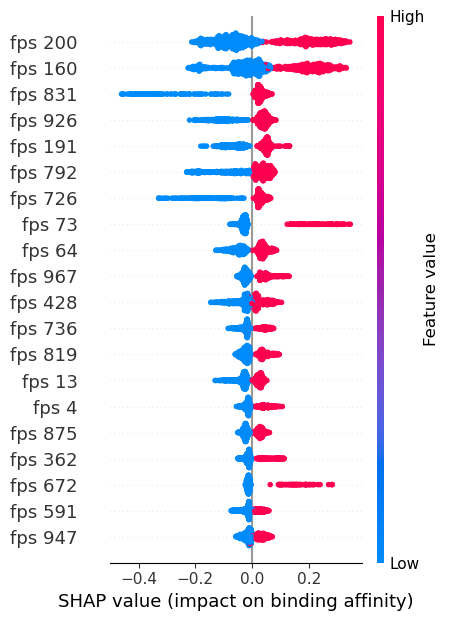

In [38]:
xgb_shap(shap_values_fps, X_fps_train, 20, 'fps')

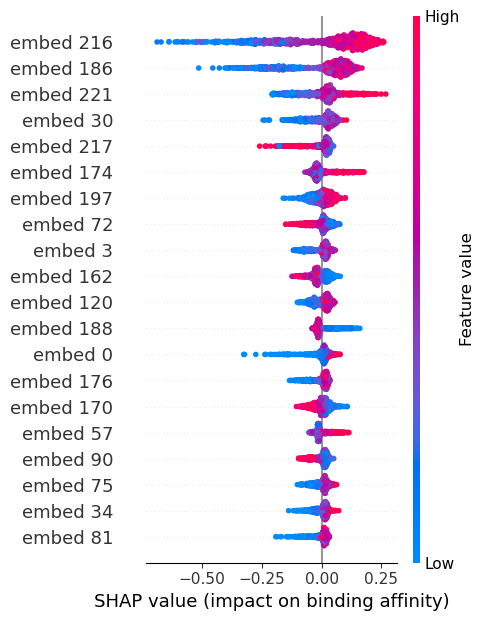

In [39]:
xgb_shap(shap_values_embed, X_embed_train, 20, 'embed')

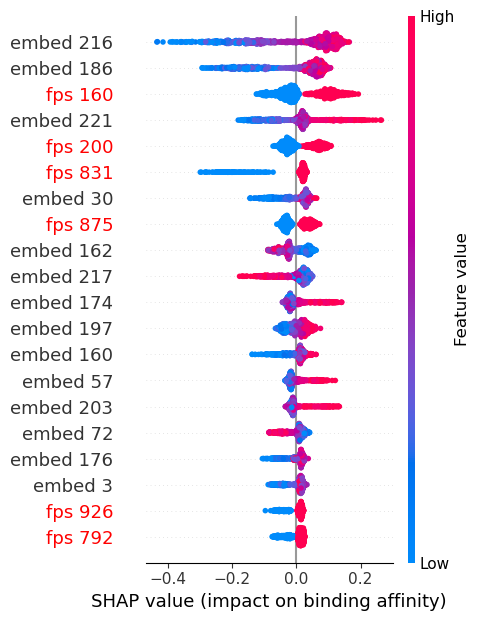

In [44]:
xgb_shap(shap_values_join, X_join_train, 20, 'joint')